
#Introduction



Ghent University's Laboratory of Microbiology is conducting the Mibirem project, an experimental study, aiming to optimize the preservation of microbial consortia. The preservation methods under evaluation involve lyophilization at room temperature using two distinct techniques (LYO1 and LYO2) and storage at ultra-low temperatures, either -80 °C (CRYO1) or -196 °C (CRYO2). Simultaneously, seven different preservation media labeled as A, B, C (cryopreservationD), and D, E, F, G (lyophilization) are being tested. Fourteen scenarios, combining different preservation methods (lyophilization and cryopreservation) and media types, are being tested. \

To assess the survival rates of microbial consortia under these varied conditions, the researchers collect samples at different time points: 0, 3, 6, 12, 18, 24, and 30 months after initiating storage, with time point 0 representing the moment before storage. The primary focus is on the initial measurement and the 3-month time point, and for each scenario, five tubes containing the microbial consortium are stored for subsequent flow cytometry analysis. \

Flow cytometry, a rapid, reproducible, and cost-effective technique, is employed to quantify total bacterial numbers and assess the live/dead ratio of bacterial cells. The researchers have compiled four distinct datasets, capturing the percentage of live, injured, and dead bacteria in each sample, along with the total number of bacterial cells. Each sample undergoes three measurements for each parameter. \

In this project, the central research question is: Does the CRYO2 preservation method have an effect over time on stored samples, and does this effect vary across different preservation media? \

In [1]:
install.packages("ggridges")
install.packages("grid")
install.packages("gridExtra")
library(grid)
library(gridExtra)
library(ggridges)
library(tidyr)
library(tidyverse)
library(MASS)
library(boot)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘grid’ is a base package, and should not be updated”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ purrr     1.0.2
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ ggplot2   3.4.4     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




# Variables, replicates and hypotheses

In this study, the response variable is the percentage of survived bacteria. The explanatory variables are the preservation media and time. The percentage of living cells was measured three times from the same aliquot with the same device, which makes this a pseudoreplication. The measurements were not performed on independent samples. For each scenario, five tubes containing the microbial consortium were used, on which parallel measurements were performed. Thus, these five subsamples are biological replicates.

H0_1: On average, there is no difference on the survival of the bacteria between timepoint zero months and after timepoint 3 months using any of the preservation media.\
H1_1: On average, there is a difference on the survival of the bacteria between timepoint zero months and after timepoint 3 months using any of the preservation media. \

If the first null hypothesis can be rejected and the alternative hypothesis is accepted, the following hypothesis can be subsequently investigated.

H0_2: On average, there is no difference on the survival of the bacteria between timepoint zero months and timepoint 3 months when stored in medium A. \
H0_3: On average, there is no difference on the survival of the bacteria between timepoint zero months and timepoint 3 months when stored in medium B. \
H0_4: On average, there is no difference on the survival of the bacteria between timepoint zero months and timepoint 3 months when stored in medium C. \

H1_2: On average, there is a difference on the survival of the bacteria between timepoint zero months and timepoint 3 months when stored in medium A. \
H1_3: On average, there is a difference on the survival of the bacteria between timepoint zero months and timepoint 3 months when stored in medium B. \
H1_4: On average, there is a difference on the survival of the bacteria between timepoint zero months and timepoint 3 months when stored in medium C.


# Data Exploration

In this study, we encountered pseudoreplication due to the nature of the experimental design. Multiple measurements were taken on the same aliquot using the same device, introducing potential dependencies between observations. To address this, we needed a reliable method to aggregate these repeated measurements and mitigate the risk of inflated significance levels.

In our case, the three measurements taken for each sample were averaged, providing a representative value for analysis. This not only addresses the challenge of pseudoreplication but also facilitates a more accurate assessment of differences in bacterial survival between timepoints and preservation media.

In [5]:
cell_count <- read.csv("Cell_Count_v2.txt", header=TRUE, sep="\t")
cell_count$Medium <- as.factor(cell_count$Medium)
cell_count$Method <- as.factor(cell_count$Method)
cell_count$Timepoint <- as.factor(cell_count$Timepoint)

data <- cell_count %>%
  filter(Method %in% c("CRYO2", "None"))
data <- data[, c("sample_name", "percent_live_1", "percent_live_2", "percent_live_3", "Medium", "Timepoint")]

data <- data  %>%
  mutate(
    mean_percent_live = rowMeans(across(starts_with("percent_live")), na.rm = TRUE),
    std_dev = apply(across(starts_with("percent_live")), 1, sd, na.rm = TRUE),
    variance = std_dev^2) %>%
  arrange(desc(row_number() %in% (nrow(.) - 4):nrow(.)))
data$Medium <- factor(data$Medium, levels = c("None","A", "B", "C"))
data

sample_name,percent_live_1,percent_live_2,percent_live_3,Medium,Timepoint,mean_percent_live,std_dev,variance
<chr>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
Unpreserved_01,75.30,74.00,74.78,None,0,74.69333,0.6543190,0.4281333
Unpreserved_02,75.74,71.83,74.42,None,0,73.99667,1.9890785,3.9564333
Unpreserved_03,76.77,74.47,75.17,None,0,75.47000,1.1789826,1.3900000
Unpreserved_04,74.78,74.22,74.47,None,0,74.49000,0.2805352,0.0787000
Unpreserved_05,73.93,71.92,75.39,None,0,73.74667,1.7422495,3.0354333
CRYO2_A_01,63.81,67.44,64.40,A,3,65.21667,1.9479305,3.7944333
CRYO2_B_01,67.28,64.65,67.15,B,3,66.36000,1.4823292,2.1973000
CRYO2_C_01,65.85,64.02,65.76,C,3,65.21000,1.0315522,1.0641000
CRYO2_A_02,75.34,63.25,62.61,A,3,67.06667,7.1720592,51.4384333


In the table above, the standard deviation was added as a statistical measure to evaluate the extent of variation among the three replicates. This metric proves valuable in quantifying the dispersion or spread of data points relative to their mean. Overall, most of the standard deviations lie in a range between 0 and 3, which is acceptable given that mean ranges between 55 and 75. However some higher standard deviations are observed at the following samples: CRYO2_A_02, CRYO2_B_02, CRYO2_B_04 and CRYO2_C_05. For these samples, a standard deviation of respectively 7.1720592, 3.4788504, 4.6167232, and 4.5352214 was calculated, indicating a larger spread between each measurement. The variance was added to the table to further look into the variation among the three replicates. For CRYO2_A_02, the calculated variance is 51.4384333, which is very close to the mean (67.06667), although it does not pose a problem as the variance is still lower than the mean. This variation is unwanted as we want reproducible measurements, a higher standard deviation and variance might indicate an error in measurements or handling of the different samples.


In [ ]:
# Group by Medium and Timepoint and calculate mean, variance, and standard deviation
mean_var_std <- data %>%
  group_by(Timepoint) %>%
  summarize(
    mean_percent_live = mean(c(percent_live_1, percent_live_2, percent_live_3), na.rm = TRUE),
    variance_percent_live = var(c(percent_live_1, percent_live_2, percent_live_3), na.rm = TRUE),
    std_dev_percent_live = sd(c(percent_live_1, percent_live_2, percent_live_3), na.rm = TRUE)
  )

# Print the result
print(mean_var_std)

# A tibble: 2 × 4
  Timepoint mean_percent_live variance_percent_live std_dev_percent_live
  <fct>                 <dbl>                 <dbl>                <dbl>
1 0                      74.5                  1.65                 1.29
2 3                      64.6                 32.7                  5.72


In the table above, the mean percentage of living cells at time point 0 is 74.5% and the variance is 1.65%. The relatively low variance compared to the mean indicates a reasonable fit to a less dispersed distribution. At time point 3, the mean drops to 64.6% and the variance increases to 32.7%.

In [ ]:
# Group by Medium and Timepoint and calculate mean, variance, and standard deviation
mean_var_std <- data %>%
  group_by(Medium) %>%
  summarize(
    mean_percent_live = mean(c(percent_live_1, percent_live_2, percent_live_3), na.rm = TRUE),
    variance_percent_live = var(c(percent_live_1, percent_live_2, percent_live_3), na.rm = TRUE),
    std_dev_percent_live = sd(c(percent_live_1, percent_live_2, percent_live_3), na.rm = TRUE)
  )

# Print the result
print(mean_var_std)

# A tibble: 4 × 4
  Medium mean_percent_live variance_percent_live std_dev_percent_live
  <fct>              <dbl>                 <dbl>                <dbl>
1 None                74.5                  1.65                 1.29
2 A                   65.7                 14.6                  3.82
3 B                   65.2                 16.7                  4.09
4 C                   62.9                 66.5                  8.16


Upon examining different media categories, we delved into the presence of overdispersion within each medium. The findings reveal that, before storage and after storage in media A and B, there are no signs of overdispersion, as the variance consistently falls short of surpassing the mean. However, upon closer inspection of medium C, post-storage, overdispersion becomes apparent.
Interestingly, despite the identification of overdispersion in medium C, the decision to adopt an overdispersion model requires thoughtful consideration. This is due to the relatively subtle discrepancy between the mean and variance.


The data's variability will be further examined through boxplots. First, the original dataset with all the percentages of live bacteria will be used.

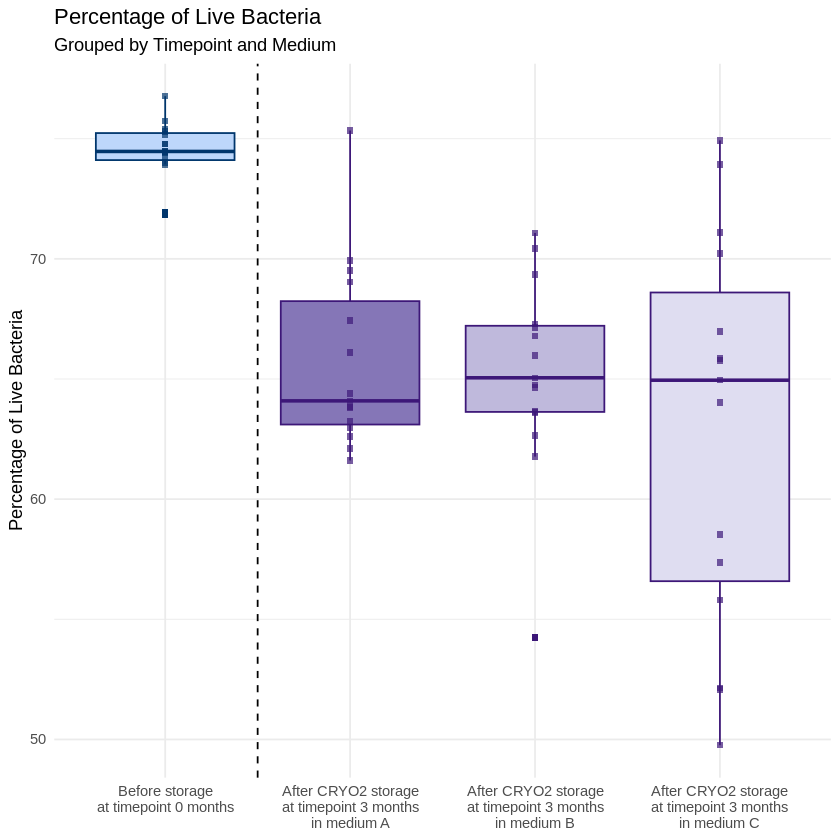

In [8]:
# Gather the percent_live columns into a single column
data_long <- data %>%
  gather(key = "Replicate", value = "percent_live", percent_live_1:percent_live_3) %>%
  mutate(Replicate = gsub("percent_live_", "", Replicate))
data_long <- data_long[, c("Medium", "Timepoint", "Replicate", "percent_live")]
data_long <- data_long %>% arrange(Timepoint)

# Boxplot not using the means
ggplot(data_long, aes(x = Medium, y = percent_live)) +
  geom_boxplot(color= c('#00366C', '#3D1778', '#3D1778', '#3D1778'),  fill = c('#BDD7FB', '#8576B7', '#BFB9DC', '#DFDDF1'), outlier.shape =15) +
  geom_point(color = c(rep('#00366C', 15), rep('#3D1778', 45)), alpha=0.7, shape=15) +
  labs(title = "Percentage of Live Bacteria",
       subtitle = 'Grouped by Timepoint and Medium',
       y = "Percentage of Live Bacteria") +
  scale_x_discrete(labels = c("Before storage\nat timepoint 0 months", "After CRYO2 storage\nat timepoint 3 months\nin medium A", "After CRYO2 storage\nat timepoint 3 months\nin medium B", "After CRYO2 storage\nat timepoint 3 months\nin medium C")) +
  geom_vline(xintercept = 1.5, linetype = "dashed", color = "black") +
  theme_minimal() +
  theme(axis.title.x=element_blank())

Analyzing the boxplots for all the percentages of live bacteria in each medium reveals noticeable variation, indicating unequal dataset variance. The distinct interquartile ranges further support this observation.

Although median values across media show little difference, the initial median at timepoint 0 months exceeds those after a 3-month storage in mediums A, B, or C, suggesting a potential decrease in the percentage of living cells over this period.

However, as the mean percentages are taken to combat the pseudoreplication issue, the mean percentage of the live bacteria will be used to investigate the data's variability and not the actual percentages.

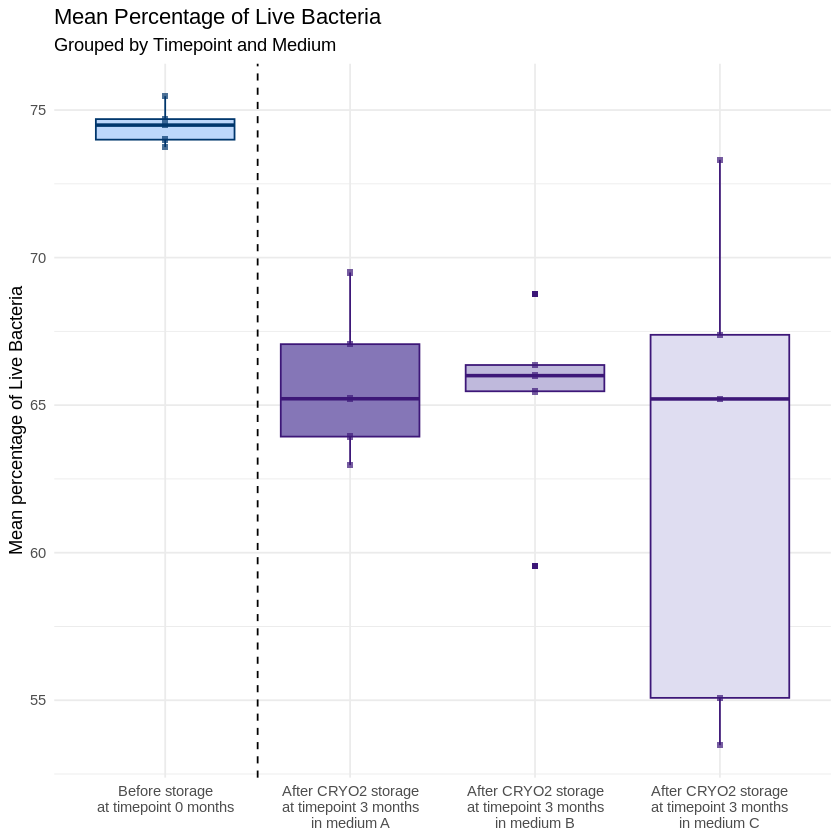

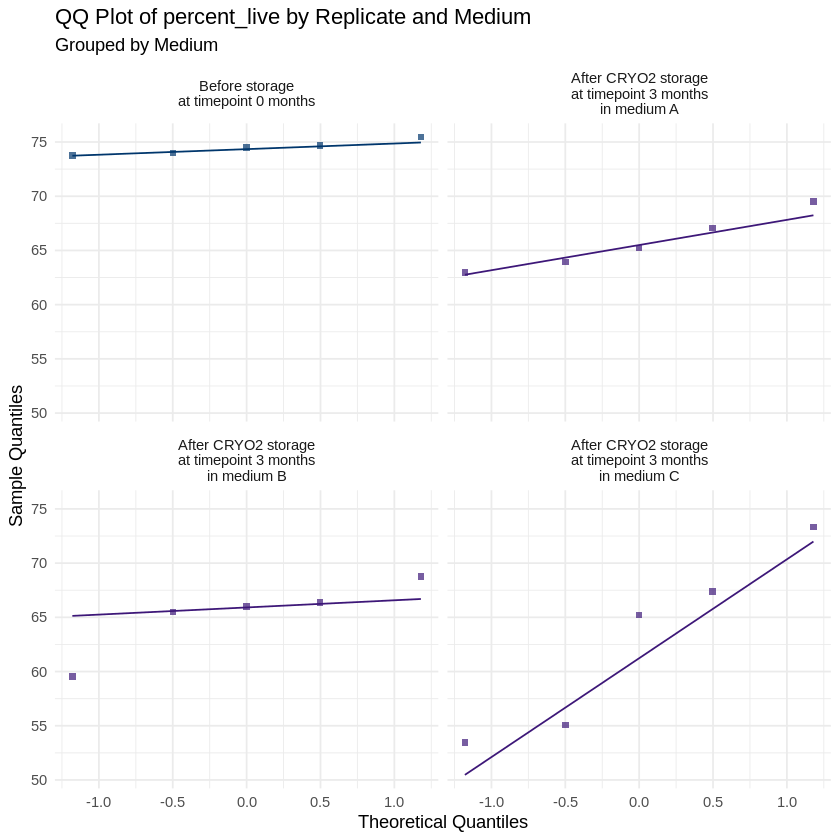

In [36]:
# Boxplot using ggplot using the means
ggplot(data, aes(x = Medium, y = mean_percent_live, col=Medium)) +
  geom_boxplot(color= c('#00366C', '#3D1778', '#3D1778', '#3D1778'),  fill = c('#BDD7FB', '#8576B7', '#BFB9DC', '#DFDDF1'), outlier.shape =15) +
  geom_point(color = c(rep('#00366C', 5), rep('#3D1778', 15)), alpha=0.7, shape=15) +
  labs(title = "Mean Percentage of Live Bacteria",
       subtitle = 'Grouped by Timepoint and Medium',
       y = "Mean percentage of Live Bacteria") +
  scale_x_discrete(labels = c("Before storage\nat timepoint 0 months", "After CRYO2 storage\nat timepoint 3 months\nin medium A", "After CRYO2 storage\nat timepoint 3 months\nin medium B", "After CRYO2 storage\nat timepoint 3 months\nin medium C")) +
  geom_vline(xintercept = 1.5, linetype = "dashed", color = "black") +
  theme_minimal() +
  theme(axis.title.x=element_blank())

# QQ-plot using ggplot
ggplot(data, aes(sample = mean_percent_live)) +
  geom_qq(color = c(rep('#00366C', 5), rep('#3D1778', 15)), alpha=0.7, shape=15) +
  geom_qq_line(color = c(rep('#00366C', 2), rep('#3D1778', 6))) +
  facet_wrap(~Medium, labeller = labeller(Medium = c('None' = 'Before storage\nat timepoint 0 months', 'A' = 'After CRYO2 storage\nat timepoint 3 months\nin medium A', 'B' = 'After CRYO2 storage\nat timepoint 3 months\nin medium B', 'C' = 'After CRYO2 storage\nat timepoint 3 months\nin medium C'))) +
  labs(title = "QQ Plot of percent_live by Replicate and Medium",
       x = "Theoretical Quantiles",
       y = "Sample Quantiles",
       subtitle = "Grouped by Medium") +
  theme_minimal()

Upon exploring the boxplots representing the mean percentages of live bacteria per medium, it becomes evident that there exists unequal variance within the dataset. This observation is substantiated by the obvious distinction in interquartile ranges among the various mean percentages of live bacteria per medium. However, when comparing only the first timepoint and medium B, equal variance is observed.

While median values between the media are closely aligned, suggesting no significant differences, the median value at the experiment's onset (Timepoint 0 months) surpasses those observed after a 3-month storage period in mediums A, B, or C. This gives a first indication that the percentage of living cells is decreased after 3 months of storage. With only 5 data points per boxplot, the median can easily be influenced by a single data point that's not quite an outlier but stands out from the others. This can make the boxplot's interquartile range significantly larger. So, the interquartile range of the boxplot might be influenced by individual data points that don't quite fit in with the rest, resulting in unequal variance.

Within the data for Medium B, two outliers CRYO2_B_02 (68.76) and CRYO_02_B_04 (59.56) are identified. These outliers, coincidentally associated with higher standard deviations, could pose challenges for the statistical model, complicating the fitting process.

The analysis is constrained by a small sample size, comprising only five data points. This limitation affects the reliability of statistical tools such as quantile-quantile (QQ) plots, traditionally more robust with larger datasets. Caution is advised when interpreting results, and findings should be considered preliminary. Supplementing analyses with additional methods and recognizing the impact of small sample variability is crucial for a more nuanced understanding of the data. Considering this, the QQ-plots indicate a normal distribution. The sample quantiles show no big deviations from the theoretical quantiles as the data points on the QQ plot align closely to the straight line.

The statistical analysis will be continued with the means of the percentages of live bacteria to combat the pseudoreplication issue.

# Model selection and statistical inference

### Model for the timepoint
To investigate the first null hypothesis, the percentage of live cells at the first timepoint will be compared to the percentage of live cells after 3 months of storage in either of the media. This will be done to investigate if there is a statistical effect in the percentage of live cells over time when storing the samples by the CRYO2 method.

First, a Welch Two Sample t-test is employed to assess whether the percentage of live cells at timepoint 0 differs significantly from the percentage of live cells after three months of storage. This test is chosen due to the comparison between two groups: the initial timepoint before storage and the subsequent timepoint after 3 months, with the Welch correction applied to account for unequal variances. This t-test is used to assess the first null hypothesis.

In [9]:
t_test <- t.test(data$mean_percent_live~data$Timepoint, var.equal=FALSE)
t_test


	Welch Two Sample t-test

data:  data$mean_percent_live by data$Timepoint
t = 7.1498, df = 15.291, p-value = 2.991e-06
alternative hypothesis: true difference in means between group 0 and group 3 is not equal to 0
95 percent confidence interval:
  6.925494 12.794506
sample estimates:
mean in group 0 mean in group 3 
       74.47933        64.61933 


The t-test yielded a t-value of 7.1498 with 15.291 degrees of freedom, resulting in an extremely significant p-value of 2.991e-06 (p < 0.001). This p-value leads us to reject the first null hypothesis.

Furthermore, a 95 percent confidence interval for the true difference in means was calculated to be between 6.925494 and 12.794506. This interval provides a range within which we can be 95% confident the actual difference in means lies.

To further investigate this difference, generalized linear models will be employed.

#### Poisson Generalized Linear Model

First, the Poisson model will be used to see if this results in a reliable model suitable for this dataset, since there is count data.

Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 74.693333”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 73.996667”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 75.470000”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 74.490000”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 73.746667”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 65.216667”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 66.360000”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 65.210000”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 67.066667”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 68.760000”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 73.313333”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 62.966667”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 67.383333”
Warning message in dpois(y, mu, log = TRUE):
“non-i

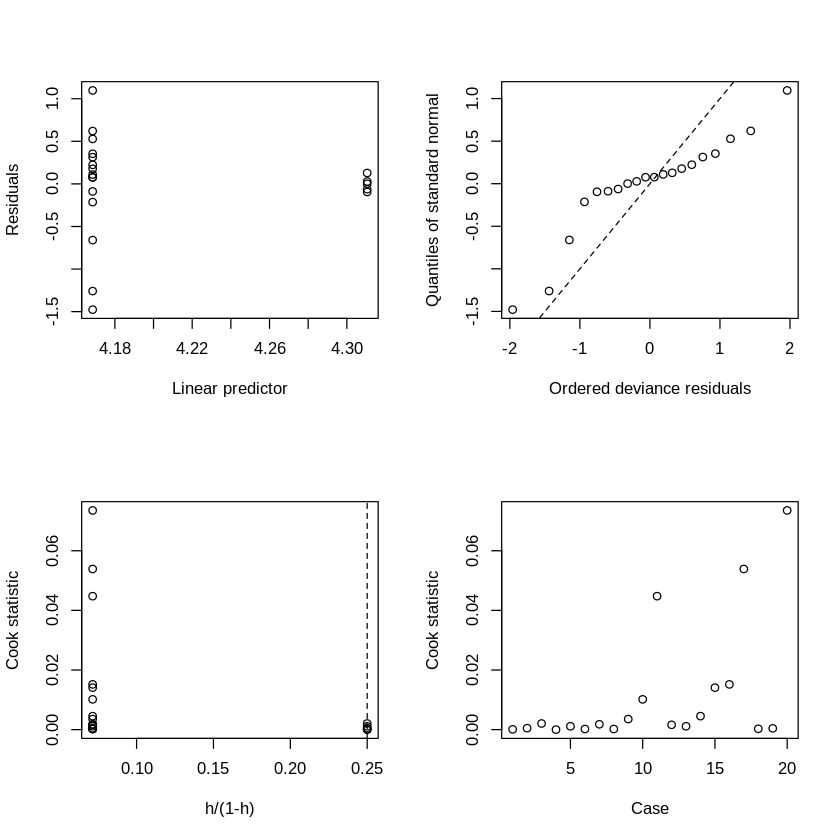

In [13]:
# Perform Poisson Generalized Linear Model
model_poisson <- glm(mean_percent_live~Timepoint, data=data, family=poisson)
# Make diagnostic plots
glm.diag.plots(model_poisson)

The upper left plot validates the homoscedasticity between the groups. The distribution of residuals deviates from the ideal scenario of equal scattering around zero between the two groups, indicating the presence of heteroscedasticity. Specifically, there is a notable increase in variability among the samples at timepoint 3 months, while the samples at timepoint zero months exhibit less variability, as evidenced by their closer proximity. It's important to note that the group at timepoint zero months comprises fewer data points compared to the group at timepoint 3 months. This difference in sample size could potentially influence the observed variability in the spreading of residuals.

The upper right plot functions as a diagnostic tool to evaluate whether the data points follow a Poisson distribution. In an optimal scenario, the ordered deviance residuals would closely follow the theoretical Poisson distribution line, indicating a Poisson-distributed dataset. However, the deviations observed from the expected Poisson distribution line imply a divergence from an ideal Poisson distribution within the dataset.

The lower left  plot represents the Cook's distance plot which is a valuable diagnostic tool used to assess the influence of individual observations on a statistical model. In this plot, each point represents an observation, and its vertical position indicates the Cook's distance, a measure of the impact of that observation on the model's fitted values.
The dashed vertical line on the plot corresponds to the threshold calculated as h/(h-1), where h is the number of model parameters. Points falling close to or to the left of this line suggest that the observations exert a typical or expected influence on the model and do not stand out as influential outliers. In this plot some data points are situated on the line, but the majority is located left to the threshold line, indicating that there are no outliers present.

The lower right plot is quite similar to the lower left plot. The y-axis indicates the Cook's distance, a measure of the impact of that observation on the model's fitted values. The x-axis corresponds to the case or observation number, with each point on the plot indicating a specific data point in your dataset. There is no dashed horizontal line, indicating the threshold value, visible in the plot, as the data points are located below it and there are no outliers present.


In [14]:
summary(model_poisson)


Call:
glm(formula = mean_percent_live ~ Timepoint, family = poisson, 
    data = data)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  4.31052    0.05182  83.183   <2e-16 ***
Timepoint3  -0.14201    0.06097  -2.329   0.0198 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 11.3620  on 19  degrees of freedom
Residual deviance:  6.0525  on 18  degrees of freedom
AIC: Inf

Number of Fisher Scoring iterations: 3


The observed deviations from ideal scenarios, such as the heteroscedasticity in the upper left plot and the departure from a Poisson distribution in the upper right plot, suggest limitations in the fit of the Poisson model to the data. Adding to this, the infinite AIC (Akaike Information Criterion) value reinforces the notion that the Poisson model is not a suitable fit for the dataset. The AIC serves as a measure of model goodness-of-fit, with lower values indicating a better fit. An infinite AIC suggests that the Poisson model does not effectively capture the complexity of the data, emphasizing the need for alternative modeling approaches to better represent the underlying structure of the dataset.

It is important to note that the Poisson model could have performed better if multiple timepoints were included in the dataset. The current analysis, with measurements taken only at 0 and 3 months, may not fully capture the temporal dynamics of the underlying processes. Considering the inclusion of additional timepoints at 6, 12, 18, 24, and 30 months could provide a more comprehensive understanding of the data. A more extensive dataset could potentially reveal patterns and trends over time, enhancing the suitability of the Poisson model for capturing the observed variability.

Given these considerations, we plan to investigate other models that may better accommodate the characteristics of the data and provide a more accurate representation of the underlying processes.

#### Negative Binomial Generalized Linear Model

In our quest for a better model following the limitations of the Poisson model, we are considering various alternatives to achieve a more optimal fit for our dataset. An alternative that is often explored in such situations is the negative binomial model. This model is designed to address overdispersion, where the variability in the data exceeds what the Poisson model can account for. Overdispersion occurs when the variance of the data is greater than the mean. The negative binomial model is specifically tailored to handle such overdispersion and can perform effectively in this scenario. However, in our data set, the variance is lower than the mean value of the percentage of living bacteria, indicating that the negative binomial model is also not appropriate. Given this, the negative binomial model is not suitable for our dataset so we are continuing our exploration of alternative models that may be more appropriate for our dataset.

Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 74.693333”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 73.996667”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 75.470000”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 74.490000”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 73.746667”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 65.216667”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 66.360000”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 65.210000”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 67.066667”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 68.760000”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 73.313333”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 62.966667”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 67.383333”
Warning message in dpois(y, mu, log = TRUE):
“non-i

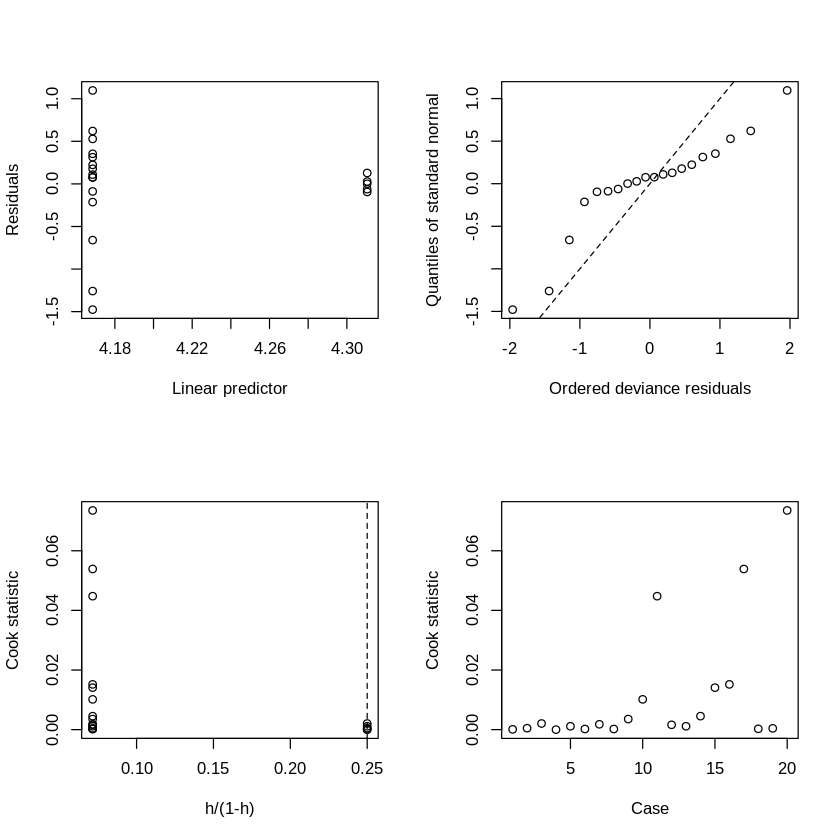

In [15]:
model_negative_binomial <- glm.nb(mean_percent_live~Timepoint, data=data)
glm.diag.plots(model_negative_binomial)

Similar to the 2 previous models, the upper left plot indicates that there is heteroscedasticity, since the two groups scatter differently around zero.

However, the upper right plot indicates that the data does not follow a negative binomial distribution, since the ordered deviance residuals are not aligning with the theoretical negative binomial distribution line.

The two lower plots are again very similar to the previous models, as the data points do not cross the thresholds, indicating that there are no outliers present.


In [16]:
summary(model_negative_binomial)


Call:
glm.nb(formula = mean_percent_live ~ Timepoint, data = data, 
    init.theta = 4038620.625, link = log)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  4.31052    0.05182  83.182   <2e-16 ***
Timepoint3  -0.14201    0.06097  -2.329   0.0198 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(4038621) family taken to be 1)

    Null deviance: 11.3618  on 19  degrees of freedom
Residual deviance:  6.0524  on 18  degrees of freedom
AIC: 132.89

Number of Fisher Scoring iterations: 1


              Theta:  4038621 
          Std. Err.:  142623950 
Warning while fitting theta: iteration limit reached 

 2 x log-likelihood:  -126.893 

The AIC value is 132.89, which is lower than the Poisson model. Although this provides a better fit than the previous model, we continue looking for a model that performs better because of the lack of overdispersion of the data.

#### Gaussian Generalized Linear Model


We opted for a Gaussian Generalized Linear Model (GLM) for our analysis due to the normal distribution observed in the dataset. This choice allows us to effectively model the relationship between variables while accommodating the data's inherent distribution characteristics.

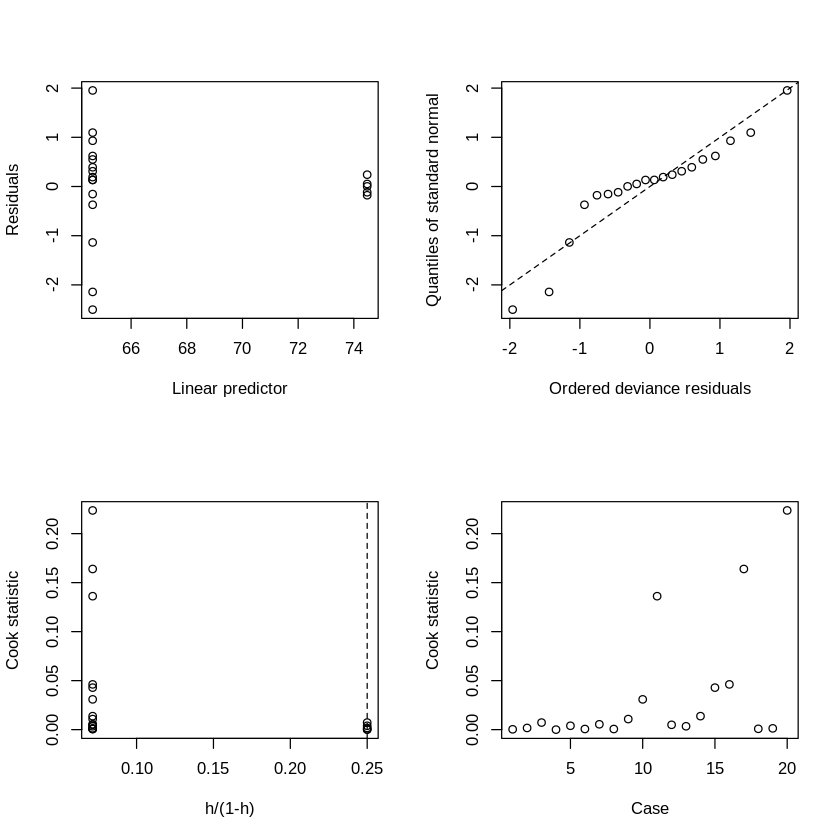

In [17]:
model_gaussian <- glm(mean_percent_live~Timepoint, data=data, family=gaussian)
glm.diag.plots(model_gaussian)

Similar to the last model, the upper left plot indicates that there is heteroscedasticity, since the two groups scatter differently around zero.

However, the upper right plot indicates that the data follows a normal distribution, since the ordered deviance residuals follow the theoretical normal distribution line.

The two lower plots are again very similar to the previous model, as the data points do not cross the thresholds, indicating that there are no outliers present.


In [18]:
summary(model_gaussian)


Call:
glm(formula = mean_percent_live ~ Timepoint, family = gaussian, 
    data = data)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   74.479      2.061  36.137  < 2e-16 ***
Timepoint3    -9.860      2.380  -4.143 0.000611 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 21.23896)

    Null deviance: 746.87  on 19  degrees of freedom
Residual deviance: 382.30  on 18  degrees of freedom
AIC: 121.77

Number of Fisher Scoring iterations: 2


The AIC of the Gaussian Generalized Linear Model is 121.77, which is lower than the Poisson and Negative Binomial model. This model provides a better fit to the data than the previous two models.

#### The Best Model

After testing several models, the Gaussian Generalized Linear Model emerged as the most effective performer. It demonstrated superior ability in fitting the data and capturing variances compared to the other two models. This is evident in the diagnostic plots, particularly the upper right plot, where the data distribution closely aligns with a normal distribution. This alignment is observed through the ordered deviance residuals, which closely follow the theoretical normal distribution line.

Furthermore, the AIC value serves as a valuable tool for model comparison. The model with the lowest AIC is considered the most favorable. In this case, the Gaussian Generalized Linear Model achieved the lowest AIC score (121.77), affirming its superiority in performance on the provided dataset.

FORMULEEEE

In [19]:
summary(model_gaussian)


Call:
glm(formula = mean_percent_live ~ Timepoint, family = gaussian, 
    data = data)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   74.479      2.061  36.137  < 2e-16 ***
Timepoint3    -9.860      2.380  -4.143 0.000611 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 21.23896)

    Null deviance: 746.87  on 19  degrees of freedom
Residual deviance: 382.30  on 18  degrees of freedom
AIC: 121.77

Number of Fisher Scoring iterations: 2


In [20]:
conf_intervals <- confint(model_gaussian)
conf_intervals

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),70.43981,78.518853
Timepoint3,-14.52444,-5.195565


* The estimated intercept (β0) is 74.479 (95% CI [70.43981, 78.518853]). This is the predicted percentage of living cells for Timepoint 0 months.
* The coefficient for Timepoint 3 months (β1) is -9.860 (95% CI [-14.52444, -5.195565]). This is the predicted difference in percentage of living cells for Timepoint 3 months compared to Timepoint 0 months. Thus the predicted percentage of living cells is 64.619 at Timepoint 3 months.
* Both intercept and coefficient have extremely significant p-values (p < 0.001), providing reason to reject the first null hypothesis. This suggest that storing over 3 months using the CRYO2 method in any of the media has a significant effect on the percentage of living cells in the samples.
* The dispersion parameter for the Gaussian family is provided (21.23896). It characterizes the variability of the residuals around the fitted values.
* The null deviance (746.87) represents the deviance of the null model (i.e., a model with no predictors). The residual deviance (382.30) represents the deviance of the fitted model. As the value gets lower, the fitted model performs better than the null model.




### Models on Medium level


To investigate the 2nd, 3rd and 4th null hypothesis, the amount of live cells before storage and after storage in respectively medium A, B or C will be  compared. Therefore, the dataset was split in three dataframes, one for each medium and the datapoints of the first timepoint. This will be done to see if the statistical effect is different for either one of the preservation media.

In [22]:
data_none_a <- data %>%
  filter(Medium == 'None' | Medium == "A")

data_none_b <- data %>%
  filter(Medium == 'None' | Medium == "B")

data_none_c <- data %>%
  filter(Medium == 'None' | Medium == "C")

Both Poisson and Gaussian generalized linear models will be checked again, as the Gaussian model may not necessarily be the most appropriate choice for our analysis when looking on a medium level. The Negative Binomial generalized linear model will only be re-evaluated on the dataframe for medium C, as the data for medium C show signs of overdispersion.

#### Poisson Generalizd Linear Model


Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 74.693333”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 73.996667”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 75.470000”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 74.490000”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 73.746667”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 65.216667”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 67.066667”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 62.966667”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 69.496667”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 63.933333”


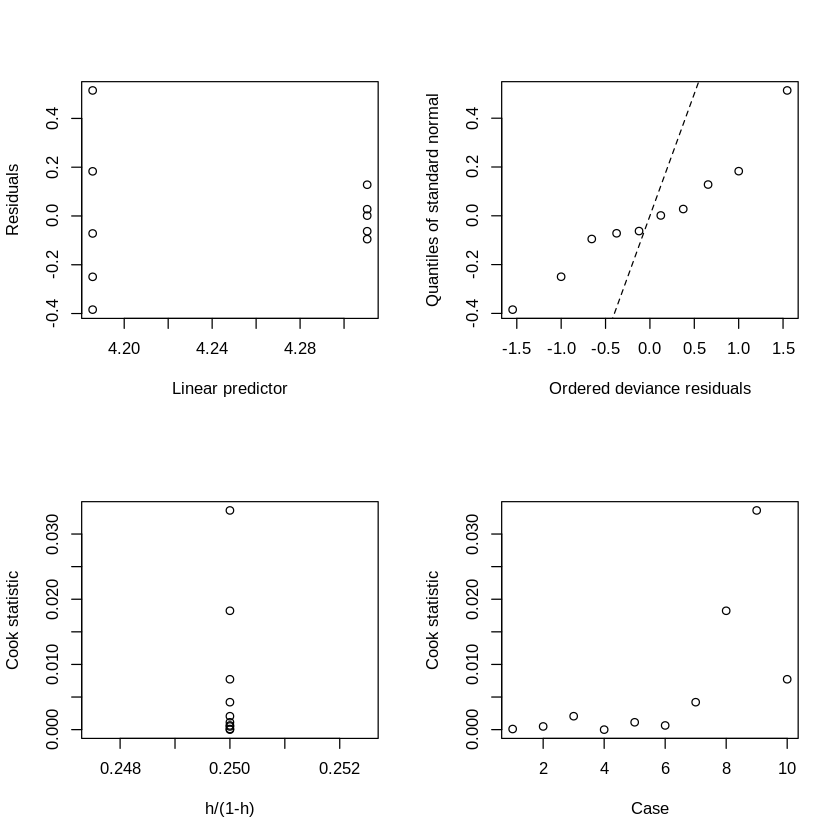

In [23]:
model_poisson_a <- glm(mean_percent_live~Timepoint, data=data_none_a, family=poisson)
glm.diag.plots(model_poisson_a)

In [24]:
summary(model_poisson_a)


Call:
glm(formula = mean_percent_live ~ Timepoint, family = poisson, 
    data = data_none_a)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  4.31052    0.05182   83.18   <2e-16 ***
Timepoint3  -0.12487    0.07568   -1.65   0.0989 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 3.16214  on 9  degrees of freedom
Residual deviance: 0.43436  on 8  degrees of freedom
AIC: Inf

Number of Fisher Scoring iterations: 3


Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 74.693333”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 73.996667”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 75.470000”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 74.490000”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 73.746667”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 66.360000”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 68.760000”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 59.556667”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 65.470000”


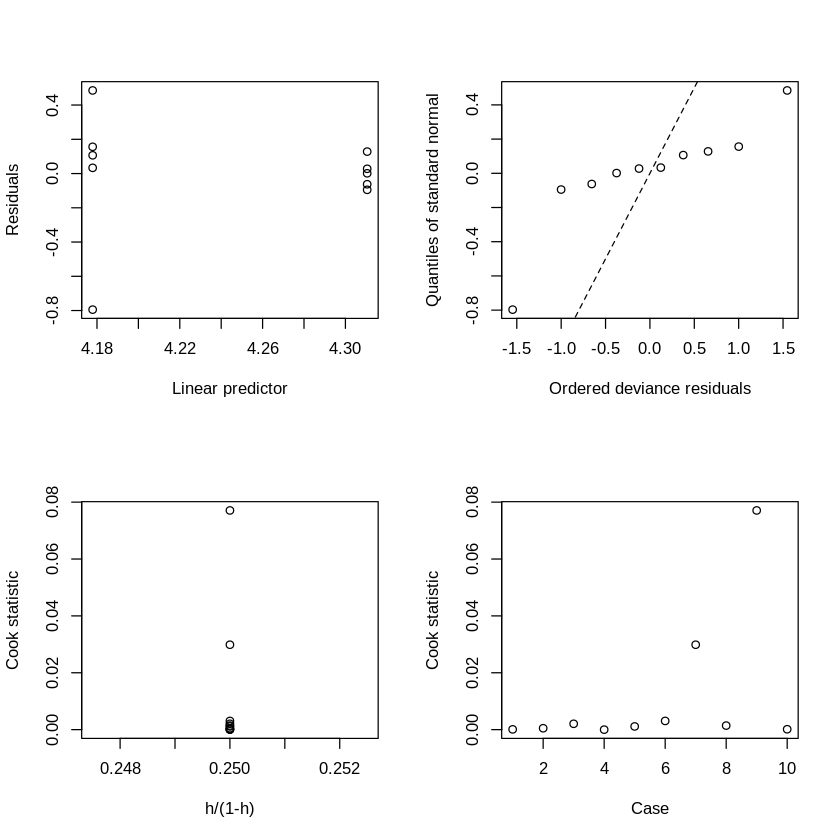

In [25]:
model_poisson_b <- glm(mean_percent_live~Timepoint, data=data_none_b, family=poisson)
glm.diag.plots(model_poisson_b)

In [27]:
summary(model_poisson_b)


Call:
glm(formula = mean_percent_live ~ Timepoint, family = poisson, 
    data = data_none_b)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  4.31052    0.05182  83.183   <2e-16 ***
Timepoint3  -0.13261    0.07584  -1.749   0.0804 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 3.81399  on 9  degrees of freedom
Residual deviance: 0.74957  on 8  degrees of freedom
AIC: Inf

Number of Fisher Scoring iterations: 3


The diagnostic plots for the poisson model for medium A and B does not show a good fit of the model to the data. On top of this, the AIC value reaches infinity, indicating that the poisson model does not capture the variance in the data.

Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 74.693333”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 73.996667”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 75.470000”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 74.490000”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 73.746667”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 65.210000”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 73.313333”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 67.383333”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 55.080000”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 53.476667”


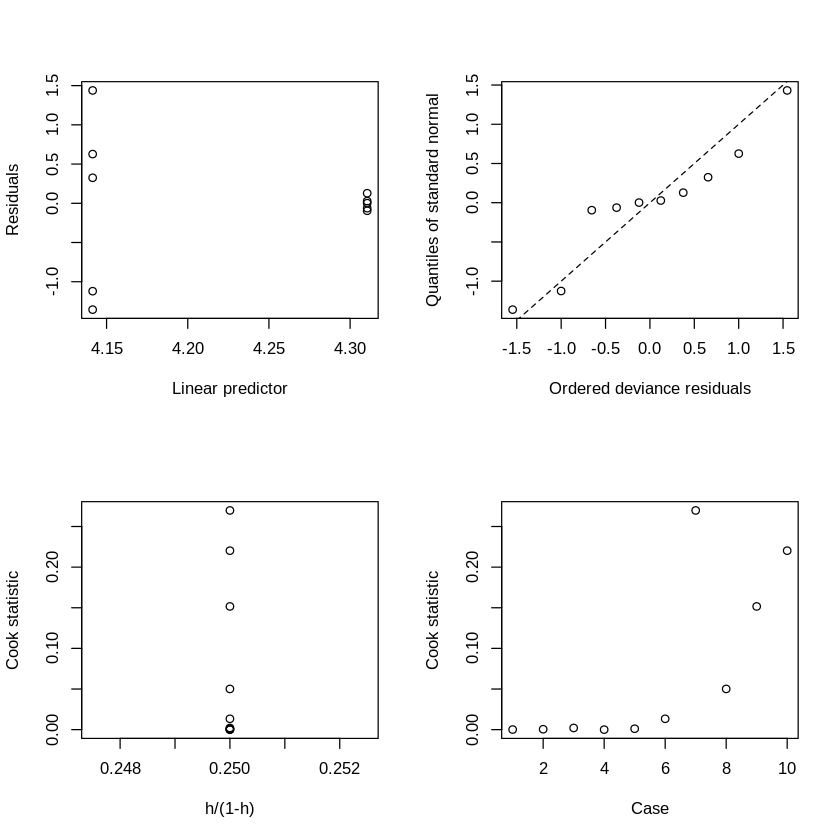

In [26]:
model_poisson_c <- glm(mean_percent_live~Timepoint, data=data_none_c, family=poisson)
glm.diag.plots(model_poisson_c)

In [29]:
summary(model_poisson_c)


Call:
glm(formula = mean_percent_live ~ Timepoint, family = poisson, 
    data = data_none_c)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  4.31052    0.05182  83.183   <2e-16 ***
Timepoint3  -0.16909    0.07659  -2.208   0.0273 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 9.4516  on 9  degrees of freedom
Residual deviance: 4.5594  on 8  degrees of freedom
AIC: Inf

Number of Fisher Scoring iterations: 4


Although the AIC value for the poisson model for medium C is also infinity, indicating a bad fit of the model to the data, the diagnostic plots show the opposite. The upper right plot indicates that the data is close to following a poisson distribution, since the ordered deviance residuals are aligning with the theoretical poisson distribution line.

The Poisson model for all cases (A, B, and C) was tested to investigate the impact of time on each medium when storing the bacteria for 3 months using the CRYO2 method. However, the Poisson model did not provide a satisfactory fit due to reasons mentioned earlier.

#### Negative Binomial

Despite the subtle difference between the mean (62.9) and variance (66.5) in the dataframe related to medium C, a negative binomial model will be tested since there is overdispersion in the data related to medium C.

Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 74.693333”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 73.996667”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 75.470000”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 74.490000”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 73.746667”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 65.210000”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 73.313333”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 67.383333”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 55.080000”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 53.476667”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


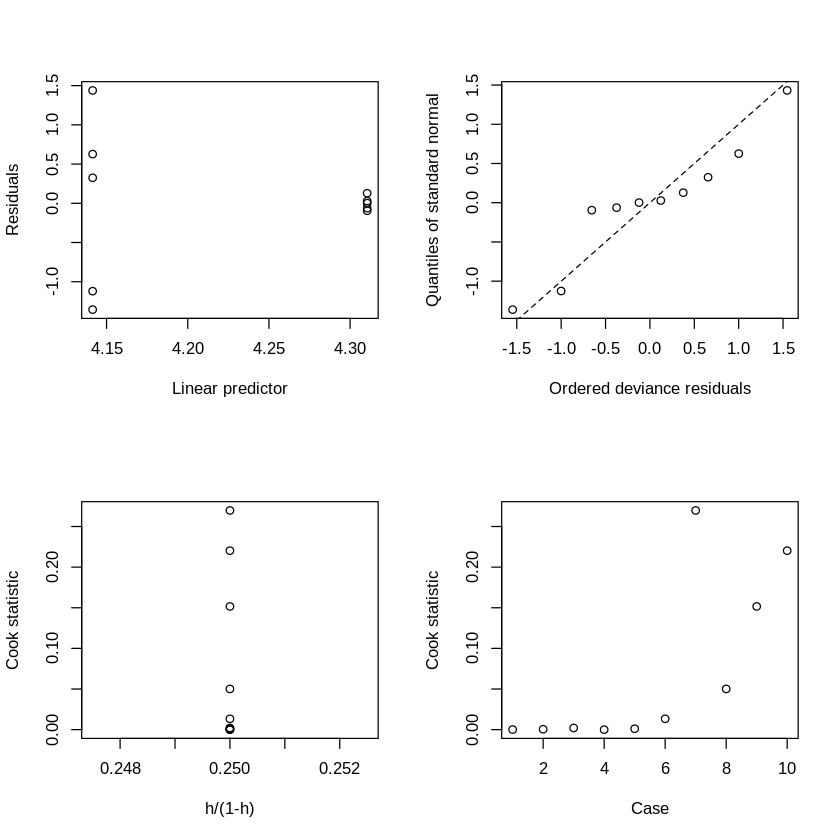

In [30]:
model_negative_binomial_c <- glm.nb(mean_percent_live~Timepoint, data=data_none_c)
glm.diag.plots(model_negative_binomial_c)

In [31]:
summary(model_negative_binomial_c)


Call:
glm.nb(formula = mean_percent_live ~ Timepoint, data = data_none_c, 
    init.theta = 2601815.288, link = log)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  4.31052    0.05182  83.181   <2e-16 ***
Timepoint3  -0.16909    0.07659  -2.208   0.0273 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(2601815) family taken to be 1)

    Null deviance: 9.4514  on 9  degrees of freedom
Residual deviance: 4.5593  on 8  degrees of freedom
AIC: 71.186

Number of Fisher Scoring iterations: 1


              Theta:  2601815 
          Std. Err.:  114052314 
Warning while fitting theta: iteration limit reached 

 2 x log-likelihood:  -65.186 

The AIC value for the negative binomial model for medium C is 71.186, indicating a reasonable fit of the model to the data. The upper right plot indicates that the data is close to following a negative binomial distribution, since the ordered deviance residuals are aligning with the theoretical negative binomial distribution line.

#### Gaussian Generalized Linear Model
Now, we aim to scrutinize the suitability of the Gaussian GLM model for each medium (A, B, and C). Despite our initial findings suggesting its effectiveness in capturing the temporal effects when storing bacteria, it remains crucial to confirm whether the Gaussian model is the best fit for each specific medium.

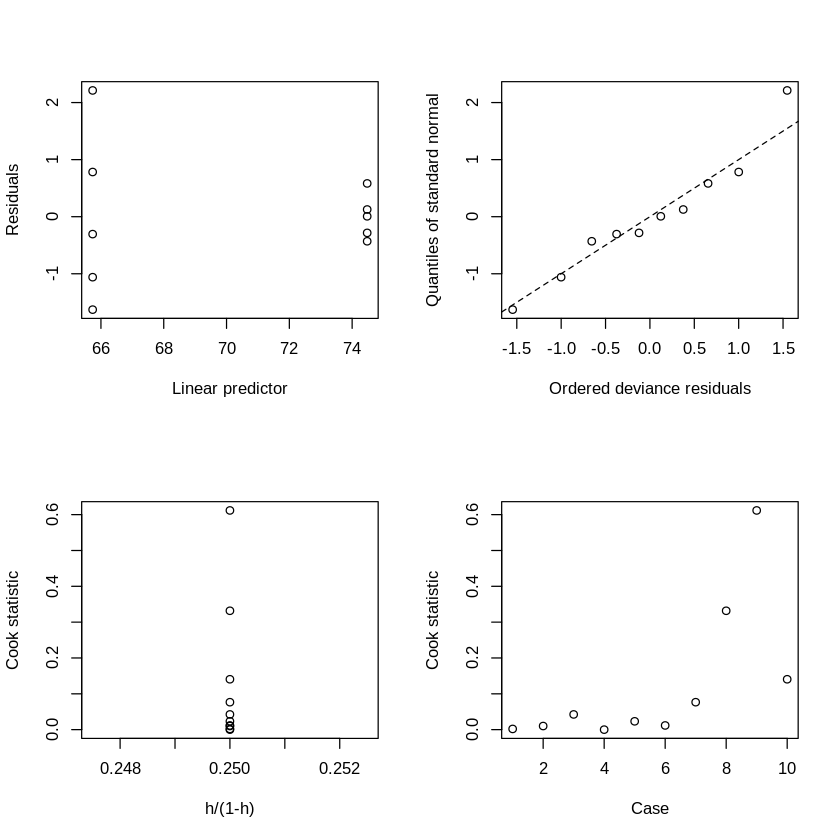

In [ ]:
model_gaussian_a <- glm(mean_percent_live~Timepoint, data=data_none_a, family=gaussian)
glm.diag.plots(model_gaussian_a)

Similar to the plots of the entire dataset, the upper left plot indicates that there is heteroscedasticity, since the two groups scatter differently around zero. The upper right plot indicates that the data follows a normal distribution, since the ordered deviance residuals follow the theoretical normal distribution line. The data points in the two lower plots do not cross the thresholds, indicating that there are no outliers present.

The theoretical normal distribution line is almost a perfect fit for the data points, indicating that this model is a very good representation of the data.

In [ ]:
summary(model_gaussian_a)


Call:
glm(formula = mean_percent_live ~ Timepoint, family = gaussian, 
    data = data_none_a)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   74.479      0.850  87.624 3.21e-13 ***
Timepoint3    -8.743      1.202  -7.274 8.61e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 3.612363)

    Null deviance: 220.014  on 9  degrees of freedom
Residual deviance:  28.899  on 8  degrees of freedom
AIC: 44.991

Number of Fisher Scoring iterations: 2


In [ ]:
conf_intervals_a <- confint(model_gaussian_a)
conf_intervals_a

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),72.81340,76.145271
Timepoint3,-11.09933,-6.387341


* The estimated intercept (β0​) is 74.479 (95% CI [72.81340, 76.145273]). This is the predicted percentage of living cells for Timepoint 0 months.
* The coefficient for Timepoint 3 months (β1) is -8.743 (95% CI [-11.09933, -6.387341]). This is the predicted difference in the percentage of living cells in Medium A for Timepoint 3 months compared to Timepoint 0 months. Thus, on average, the predicted percentage of living cells in Medium A is 65.736 at Timepoint 3 months.
* Both the intercept and coefficient have extremely significant p-values (p < 0.001), providing a reason to reject the second null hypothesis. This suggests that storing over 3 months using the CRYO2 method in Medium A has a significant effect on the percentage of living cells in the samples.
* The dispersion parameter for the Gaussian family is provided (3.612363). It characterizes the variability of the residuals around the fitted values.
* The null deviance (220.014) represents the deviance of the null model (a model with no predictors). The residual deviance (28.899) represents the deviance of the fitted model. As the value gets lower, the fitted model performs better than the null model.

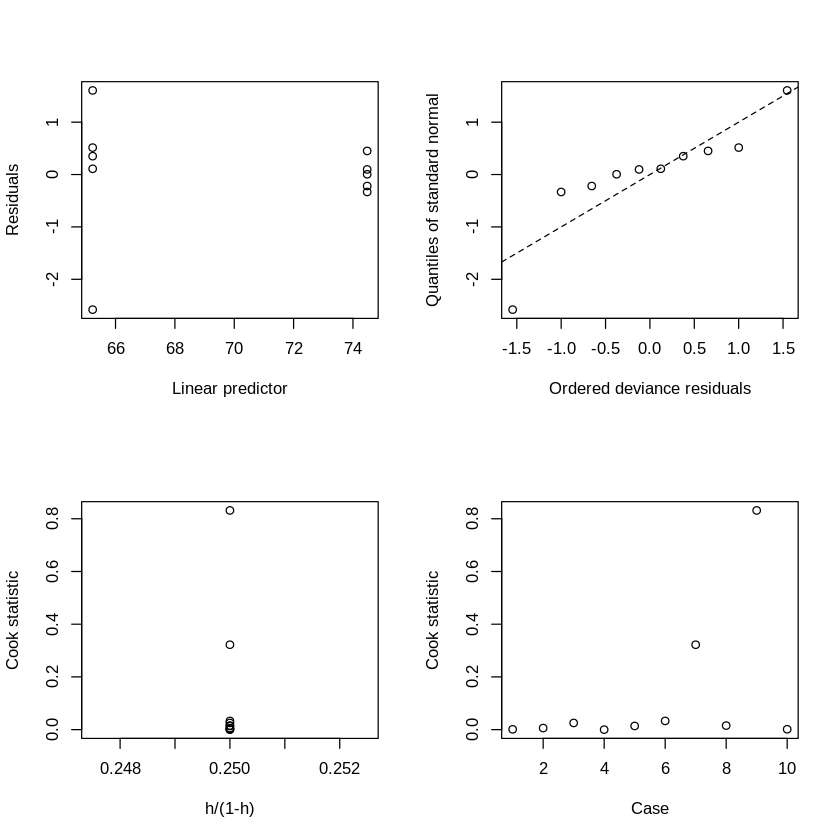

In [ ]:
model_gaussian_b <- glm(mean_percent_live~Timepoint, data=data_none_b, family=gaussian)
glm.diag.plots(model_gaussian_b)

The upper left plot indicates that there is heteroscedasticity, since the two groups scatter differently around zero.

The upper right plot indicates that the data follows a normal distribution, since the ordered deviance residuals follow the theoretical normal distribution line. However, the ordered deviance residuals follow the line with less precision, suggesting that this may not be the ideal fit. Nevertheless, an alternative poisson model was analyzed and it was found that this particular model still provided the best fit.

The data points in the two lower plots do not cross the thresholds, indicating that there are no outliers present.

In [ ]:
summary(model_gaussian_b)


Call:
glm(formula = mean_percent_live ~ Timepoint, family = gaussian, 
    data = data_none_b)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   74.479      1.100  67.728 2.51e-12 ***
Timepoint3    -9.250      1.555  -5.948 0.000343 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 6.046513)

    Null deviance: 262.278  on 9  degrees of freedom
Residual deviance:  48.372  on 8  degrees of freedom
AIC: 50.142

Number of Fisher Scoring iterations: 2


In [ ]:
conf_intervals_b <- confint(model_gaussian_b)
conf_intervals_b

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),72.32399,76.63467
Timepoint3,-12.29811,-6.20189


* The estimated intercept (β0) is 74.479 (95% CI [72.32399, 76.63467]). This is the predicted percentage of living cells for Timepoint 0 months.
* The coefficient for Timepoint 3 months (β1) is -9.250 (95% CI [-12.29811, -6.20189]). This is the predicted difference in the percentage of living cells in Medium B for Timepoint 3 months compared to Timepoint 0 months. Thus, on average, the predicted percentage of living cells stored in Medium B is 65.229 at Timepoint 3 months.
* Both the intercept and coefficient have extremely significant p-values (p < 0.001), providing a reason to reject the third null hypothesis. This suggests that storing over 3 months using the CRYO2 method in Medium B has a significant effect on the percentage of living cells in the samples.
* The dispersion parameter for the Gaussian family is provided (6.046513). It characterizes the variability of the residuals around the fitted values.
* The null deviance (262.278) represents the deviance of the null model (a model with no predictors). The residual deviance (48.372) represents the deviance of the fitted model. As the value gets lower, the fitted model performs better than the null model.

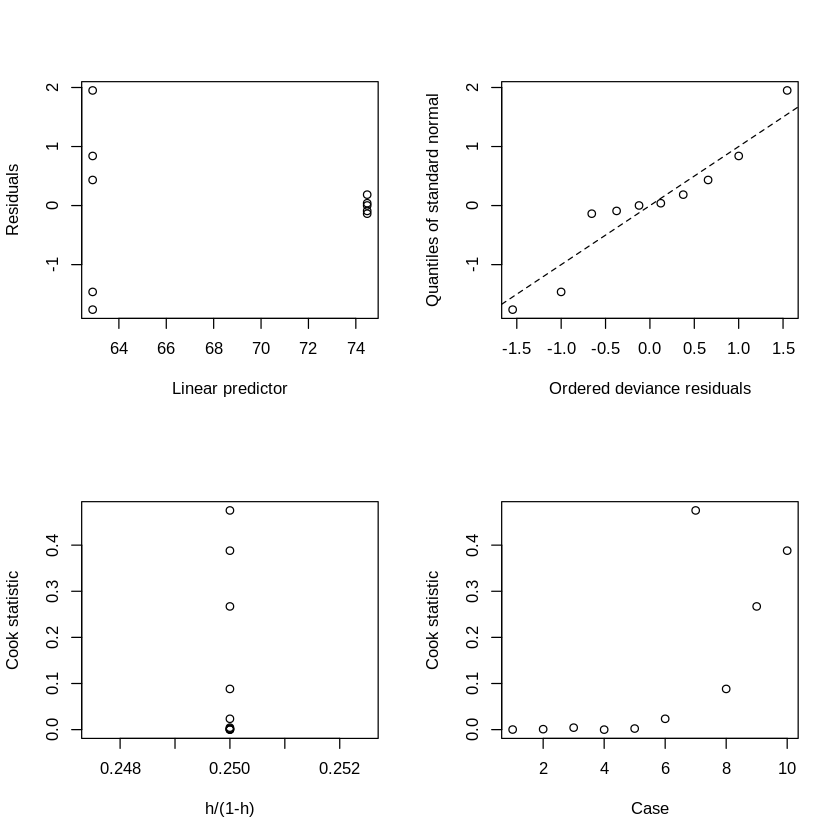

In [ ]:
model_gaussian_c <- glm(mean_percent_live~Timepoint, data=data_none_c, family=gaussian)
glm.diag.plots(model_gaussian_c)

Again, the upper left plot indicates that there is heteroscedasticity, since the two groups scatter differently around zero.

The upper right plot indicates that the data follows a normal distribution, since the ordered deviance residuals follow the theoretical normal distribution line. However, the ordered deviance residuals follow the line with less precision, suggesting that this may not be the ideal fit. Nevertheless, alternative models (poisson and negative binomial) were analyzed and it was found that this particular model still provided the best fit.

The data points in the two lower plots do not cross the thresholds, indicating that there are no outliers present.

In [ ]:
summary(model_gaussian_c)


Call:
glm(formula = mean_percent_live ~ Timepoint, family = gaussian, 
    data = data_none_c)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   74.479      2.672  27.872 2.96e-09 ***
Timepoint3   -11.587      3.779  -3.066   0.0154 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 35.70279)

    Null deviance: 621.25  on 9  degrees of freedom
Residual deviance: 285.62  on 8  degrees of freedom
AIC: 67.9

Number of Fisher Scoring iterations: 2


In [ ]:
conf_intervals_c <- confint(model_gaussian_c)
conf_intervals_c

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),69.24195,79.716714
Timepoint3,-18.99344,-4.179891


* The estimated intercept (β0) is 74.479 (95% CI [69.24195, 79.716714]). This is the predicted percentage of living cells for Timepoint 0 months.
* The coefficient for Timepoint 3 months (β1) is -11.587 (95% CI [-18.99344, -4.179891]). This is the predicted difference in the percentage of living cells in Medium C for Timepoint 3 months compared to Timepoint 0 months. Thus, on average, the predicted percentage of living cells in Medium C is 62.892 at Timepoint 3 months.
* Both the intercept and coefficient have extremely significant and significant p-values (p < 0.001 and p = 0.0154, respectively), providing a reason to reject the first null hypothesis. This suggests that storing over 3 months using the CRYO2 method in Medium C has a significant effect on the percentage of living cells in the samples.
* The dispersion parameter for the Gaussian family is provided (35.70279). It characterizes the variability of the residuals around the fitted values.
* The null deviance (621.25) represents the deviance of the null model (i.e., a model with no predictors). The residual deviance (285.62) represents the deviance of the fitted model. As the value gets lower, the fitted model performs better than the null model.

Both diagnostic plots and AIC values indicate that the Gaussian generalized linear models perform the best out of the models tested on the data on medium level.

# Conclusion

The gaussian generalized linear model revealed that there is an extremely significant (p < 0.001) difference of the survival of the bacteria between timepoint zero months and after timepoint 3 months using any of the preservation media.

The percentage of bacteria after three months of storage using the CRYO2 method in any of the preservation media decreases on average for 9.860% (95% CI [14.52444, 5.195565], p = 0.000611 < 0.001). On average, the predicted percentage of living bacteria before storage is 74.479% (95% CI [70.43981, 78.518853], p = 2e-16 < 0.001) and after 3 months of storage 64.619% of living bacteria are expected.

Furthermore, three other gaussian generalized linear model revealed that there is also an extremely significant (p < 0.001) difference on the survival of the bacteria between timepoint zero months and timepoint 3 months when stored in medium A and B. While there is only a significant (p < 0.05) difference when stored in medium C.

When the bacteria are stored for three months using the CRYO2 method in preservation medium A, B and C, there is on average a decrease of 8.743% (95% CI [11.09933, 6.387341], p = 8.61e-05 < 0.001), 9.250% (95% CI [12.29811, 6.20189], p = 0.000343 < 0.001) and 11.587% (95% CI [18.99344, 4.179891], p = 0.0154 < 0.05) of living bacteria respectively. For all the preservation media, the predicted percentage of living bacteria before storage is on average 74.479% (A: 95% CI [72.81340, 76.145273], p = 3.21e-13 < 0.001; B: 95% CI [72.32399, 76.63467], p = 2.51e-12 < 0.001; C: 95% CI [69.24195, 79.716714], 2.96e-09 < 0.001). For preservation medium A, B and C, on average, the expected percentage of living bacteria after three months of storage is 65.736%, 65.229% and 62.892%.

The results derived from the Gaussian Generalized Linear Models suggest that, on average, preservation medium A performs better than medium B and C, as it exhibits a higher percentage of bacterial survival. However, to make this statement, additional information from the later time points is essential.

The plot below visually emphasizes the observed differences in bacterial survival percentages before and after three months of storage using the CRYO2 method in various preservation media. It provides a clear representation of the trends across different conditions and supports the statistical findings derived from the Gaussian Generalized Linear Models.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘grid’ is a base package, and should not be updated”
Picking joint bandwidth of 1.95



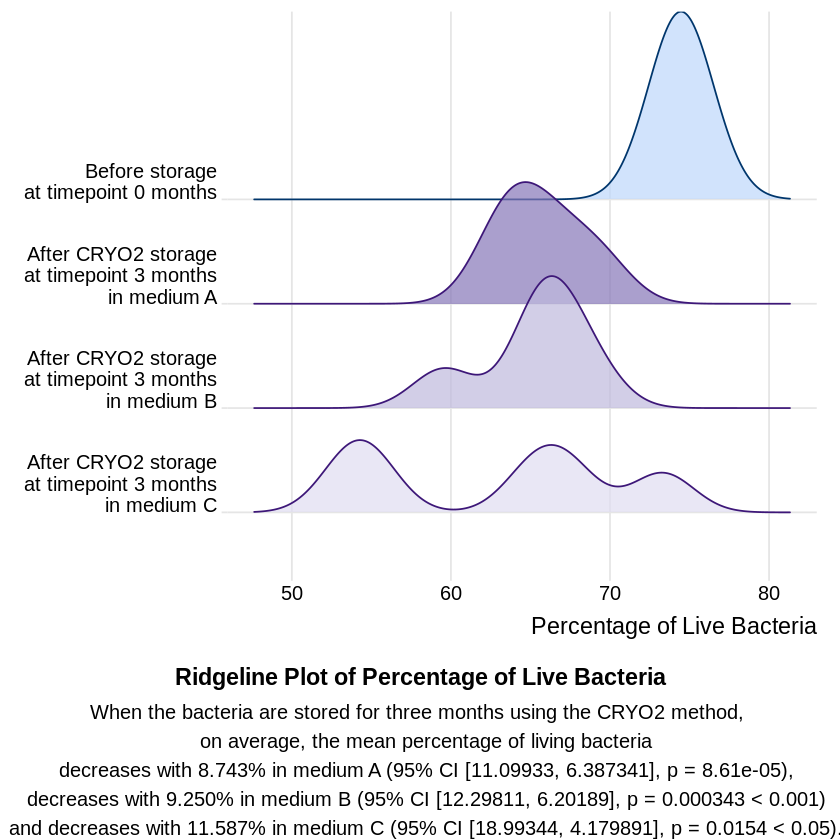

In [ ]:
# Combine the values into a data frame
data_none <- data %>% filter(Medium == 'None')
data_a <- data %>% filter(Medium == 'A')
data_b <- data %>% filter(Medium == 'B')
data_c <- data %>% filter(Medium == 'C')

ridgeline_data <- data.frame(DataTimepoint0 = data_none$mean_percent_live, DataTimepoint3_A = data_a$mean_percent_live, DataTimepoint3_B = data_b$mean_percent_live, DataTimepoint3_C = data_c$mean_percent_live)

# Melt the data for plotting
melted_data <- gather(ridgeline_data, key = "medium", value = "mean_percent_live")
melted_data$medium <- factor(melted_data$medium, levels = rev(c("DataTimepoint0", "DataTimepoint3_A", "DataTimepoint3_B", "DataTimepoint3_C")))

# Create ridgeline plot
ridgeline_plot <- ggplot(melted_data, aes(x = mean_percent_live , y = medium)) +
  geom_density_ridges(alpha = 0.7, color = c(rep('#3D1778', 1536), rep('#00366C', 512)), fill = rev(c(rep('#BDD7FB', 512), rep('#8576B7', 512), rep('#BFB9DC', 512) , rep('#DFDDF1', 512)))) +
  labs(x = "Percentage of Live Bacteria") +
  scale_y_discrete(labels = rev(c(
  "Before storage
  at timepoint 0 months",
  "After CRYO2 storage
  at timepoint 3 months
  in medium A",
  "After CRYO2 storage
  at timepoint 3 months
  in medium B",
  "After CRYO2 storage
  at timepoint 3 months
  in medium C")))+
  theme_ridges() +
  theme(axis.title.y=element_blank())

title <- textGrob("Ridgeline Plot of Percentage of Live Bacteria", gp = gpar(fontsize = 14, fontface = "bold"), just = "center")
caption <- textGrob("When the bacteria are stored for three months using the CRYO2 method,
  on average, the mean percentage of living bacteria
  decreases with 8.743% in medium A (95% CI [11.09933, 6.387341], p = 8.61e-05),
  decreases with 9.250% in medium B (95% CI [12.29811, 6.20189], p = 0.000343 < 0.001)
  and decreases with 11.587% in medium C (95% CI [18.99344, 4.179891], p = 0.0154 < 0.05).", gp = gpar(fontsize = 12), just = "center")

grid.arrange(
  ridgeline_plot,
  title,
  caption,
  nrow = 3,
  heights = c(0.7, 0.05, 0.15)
)